In [8]:
!pip install nltk
!pip install nltk scikit-learn xgboost transformers gensim

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import markers

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel, AutoTokenizer
from tokenizers import Tokenizer, models, trainers
import torch
from imblearn.over_sampling import SMOTE

In [10]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download("punkt")

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# DATASET

1. Primary dataset: Custom python code extraction of Gilbert Strang’s textbook<br>
   [questions_with_chapters.json]<br>
3. Synthetic dataset: Manually extracted dataset with synthetic question generation to create balanced dataset of Gilbert Strang’s textbook<br>
[questions_with_chapters1_manual.json]
4. Noiseless dataset: Only latex questions with no noise for book3<br>
   [questions_with_chapters3.json]

Un-comment the dataset you want to run the notebook on.

In [32]:

# ----- Primary Dataset
# df = pd.read_json("https://raw.githubusercontent.com/anushkachaubey/NLP/main/Datasets/Primary_Book1/questions_with_chapters.json")

# ----- Synthetic Dataset
# df = pd.read_json("https://raw.githubusercontent.com/anushkachaubey/NLP/main/Datasets/Synthetic_Book1/questions_with_chapters1_manual.json")

# ----- Noiseless Dataset
# df = pd.read_json("https://raw.githubusercontent.com/anushkachaubey/NLP/main/Datasets/Noiseless_Book3/questions_with_chapters3.json")



# Function Definations:

* Preprocess
* Encodings
* SMOTE distribution plot
* Evaluate model


In [12]:
# Text preprocessing function
def preprocess_text(text):
    text = text.replace("\\", " \\")  # Preserve LaTeX commands
    text= re.sub(r'^\d+\.\s*', '', text)
    text = re.sub(r"([+\-*/^=()])", r" \1 ", text)  # Ensure math symbols are separated
    return text



In [13]:
def apply_smote(X_train, y_train):
    """
    Applies SMOTE to balance the dataset.
    """

    # Find the minority class count
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    min_class_size = min(class_counts)

    # Ensure k_neighbors is always smaller than the smallest class size
    k_neighbors = min(5, min_class_size - 1) if min_class_size > 1 else 1

    smote = SMOTE(sampling_strategy="auto", k_neighbors=k_neighbors, random_state=42)
    
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    return X_train_resampled, y_train_resampled


def smoteDistr(y_train_all, y_train):
    """
    Applies SMOTE and visualizes class distribution before & after resampling.
    """
    # Get class distribution before SMOTE
    before_counts = np.bincount(y_train)
    # Get class distribution after SMOTE
    after_counts = np.bincount(y_train_all)

    # Print class distributions
    print("Before SMOTE:", before_counts)
    print("After SMOTE:", after_counts)

    # ----------------------------
    # **Bar Plot for Class Distribution**
    # ----------------------------
    labels = [f"Class {i}" for i in range(len(before_counts))]  # Class labels
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(np.arange(len(before_counts)) - width/2, before_counts, width, label="Before SMOTE", color="lightcoral")
    ax.bar(np.arange(len(after_counts)) + width/2, after_counts, width, label="After SMOTE", color="skyblue")

    # Formatting the plot
    ax.set_xticks(np.arange(len(before_counts)))
    ax.set_xticklabels(labels, rotation=45)  # Rotate for better readability
    ax.set_ylabel("Number of Samples")
    ax.set_title("Class Distribution Before & After SMOTE")
    ax.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show plot
    plt.show()



In [14]:
def tfidf(X_train_text,X_test_text):
    # ----------------------------
    # **TF-IDF Encoding**
    # ----------------------------
    vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for better performance
    X_train_tfidf = vectorizer.fit_transform(X_train_text)
    X_test_tfidf = vectorizer.transform(X_test_text)
    print(type(X_train_tfidf),X_train_tfidf.shape)
    return X_train_tfidf,X_test_tfidf

def word2vec(X_train_text,X_test_text):
    # ----------------------------
    # **Word2Vec Encoding**
    # ----------------------------
    w2v_model = Word2Vec(sentences=df["cleaned_question"], vector_size=100, window=5, min_count=2, workers=4)

    def word2vec_embedding(text):
        vectors = [w2v_model.wv[word] for word in text if word in w2v_model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(100)

    X_train_w2v = np.array([word2vec_embedding(text) for text in X_train_text])
    X_test_w2v = np.array([word2vec_embedding(text) for text in X_test_text])    
    print(type(X_train_w2v),X_train_w2v.shape)

    return X_train_w2v,X_test_w2v

def bert(X_train_text,X_test_text):
    
    # ----------------------------
    # **BERT Encoding**
    # ----------------------------
    """
    Converts text into BERT embeddings using the [CLS] token representation.
    """
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased")

    def bert_embedding(text):
        tokens = bert_tokenizer(text, padding="max_length", max_length=50, truncation=True, return_tensors="pt")
        with torch.no_grad():
            output = bert_model(**tokens)
        # Extract the [CLS] token representation (best for classification tasks)
        cls_embedding = output.last_hidden_state[:, 0, :].squeeze().numpy()
        return cls_embedding

    # Convert all texts to embeddings
    X_train_bert = np.array([bert_embedding(text) for text in X_train_text])
    X_test_bert = np.array([bert_embedding(text) for text in X_test_text])

    return X_train_bert, X_test_bert

In [15]:
def latex_tokenizer(X_train_text, X_test_text):
    # ----------------------------
    # **LaTeX Tokenizer**
    # ----------------------------
    """
    Tokenizes math questions written in LaTeX-style notation.
    """
    vectorizer = TfidfVectorizer(token_pattern=r"\\[a-zA-Z]+|\d+|[a-zA-Z]+|[-+*/^()=]", max_features=5000)
    X_train_latex = vectorizer.fit_transform(X_train_text)
    X_test_latex = vectorizer.transform(X_test_text)
    
    print(type(X_train_latex), X_train_latex.shape)

    return X_train_latex, X_test_latex

def math_symbolic_tokenizer(X_train_text, X_test_text):
    # ----------------------------
    # **Custom Symbolic Tokenizer**
    # ----------------------------
    """
    Tokenizes math expressions into numbers, variables, and operators.
    """
    def tokenize(text):
        return " ".join(re.findall(r"\d+|[a-zA-Z]+|[-+*/^()=]", text))
    
    X_train_symbolic = [tokenize(text) for text in X_train_text]
    X_test_symbolic = [tokenize(text) for text in X_test_text]
    
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_symbolic_tfidf = vectorizer.fit_transform(X_train_symbolic)
    X_test_symbolic_tfidf = vectorizer.transform(X_test_symbolic)
    
    return X_train_symbolic_tfidf, X_test_symbolic_tfidf

def mathbert_tokenizer(X_train_text, X_test_text):
    # ----------------------------
    # **MathBERT Tokenization**
    # ----------------------------
    tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBERT")
    
    def tokenize(text):
        return tokenizer(text, padding="max_length", max_length=5000, truncation=True, return_tensors="pt").input_ids.squeeze().numpy()
    
    X_train_mathbert = np.array([tokenize(text) for text in X_train_text])
    X_test_mathbert = np.array([tokenize(text) for text in X_test_text])
    
    return X_train_mathbert, X_test_mathbert


In [16]:
def evaluate_model(X_train, X_test, y_train, y_test):
    models={
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Ada Boost":AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42),
        "XGBC":  XGBClassifier( eval_metric="mlogloss")
    }


    for model_name, model in models.items():
        print(f"\n📌 {model_name} Results:")


        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        report = classification_report(y_test, preds, target_names=label_encoder.classes_, output_dict=True)
        
        print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
        # print(f"F1 Score (Macro Avg): {report['macro avg']['f1-score']:.4f}")
        # print(f"F1 Score (Weighted Avg): {report['weighted avg']['f1-score']:.4f}")

# Data Manipulation and Exploration

#### Preprocess

In [17]:
df["cleaned_question"] = df["question"].apply(preprocess_text)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["chapter"])  

#### Train-Test stratify split

In [18]:
# Split dataset into Train & Test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["cleaned_question"], y, stratify=y, test_size=0.2, random_state=42
)

#### Dataset Distribution

Total questions in the dataset:  119
Total number of chapters (labels):  10


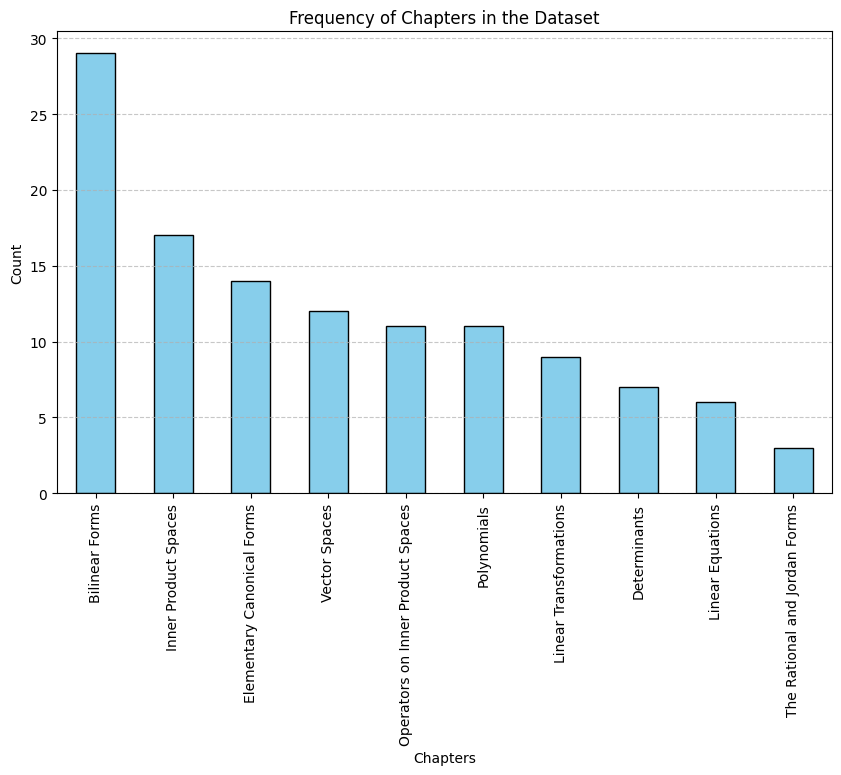

In [19]:
print("Total questions in the dataset: ",df.shape[0])
print("Total number of chapters (labels): ",len(np.unique(df["chapter"])))
import matplotlib.pyplot as plt

# Compute value counts
chapter_counts = df["chapter"].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
chapter_counts.plot(kind="bar", color="skyblue", edgecolor="black")

# Customize the plot
plt.xlabel("Chapters")
plt.ylabel("Count")
plt.title("Frequency of Chapters in the Dataset")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


# Individual Embedding Evaluation
Un-comment the below code if you want to see individual embedding evaluation

#### Different Embedding Techniques

In [20]:
# from tqdm import tqdm

# X_train_all = []
# y_train_all = []
# X_test_all = []

# functions1 = [tfidf, word2vec, bert]
# functions2 = [latex_tokenizer, math_symbolic_tokenizer, mathbert_tokenizer]
# functions = functions1 + functions2

# # Wrap the loop in tqdm for a progress bar
# for func in tqdm(functions, desc="Processing Tokenizers"):
#     print(f"Processing: {func.__name__}")
    
#     xtr_, xts_ = func(X_train_text, X_test_text)
#     xtr_, y_tr = apply_smote(xtr_, y_train)
    
#     X_train_all.append(xtr_)
#     y_train_all.append(y_tr)
#     X_test_all.append(xts_)
    
#     print(f"Completed: {func.__name__}")

# print("All tokenizers processed!")


#### SMOTE on training distribution

In [21]:
# smoteDistr(y_train_all[0], y_train)

#### Evaluate model on every embedding technique

In [22]:
# encod1 = ['tfidf', 'word2vec', 'bert']
# encod2=['latex_tokenizer','math_symbolic_tokenizer','mathbert_tokenizer']
# encod=encod1+encod2


# for i in range(len(X_train_all)):
#     print()
#     print(encod[i],"*"*30)
#     evaluate_model(X_train_all[i], X_test_all[i], y_train_all[i], y_test)

#### Output Summary

*Without stratify split:*

tfidf ******************************

📌 Random Forest Results:
Accuracy: 0.6961
F1 Score (Macro Avg): 0.6272
F1 Score (Weighted Avg): 0.6817

📌 Ada Boost Results:
Accuracy: 0.5195
F1 Score (Macro Avg): 0.4923
F1 Score (Weighted Avg): 0.4990

📌 XGBC Results:
Accuracy: 0.6982
F1 Score (Macro Avg): 0.6452
F1 Score (Weighted Avg): 0.6890

word2vec ******************************

📌 Random Forest Results:
Accuracy: 0.3860
F1 Score (Macro Avg): 0.2847
F1 Score (Weighted Avg): 0.3476

📌 Ada Boost Results:
Accuracy: 0.2936
F1 Score (Macro Avg): 0.2140
F1 Score (Weighted Avg): 0.2764

📌 XGBC Results:
Accuracy: 0.4374
F1 Score (Macro Avg): 0.3621
F1 Score (Weighted Avg): 0.4219

bert ******************************

📌 Random Forest Results:
Accuracy: 0.4333
F1 Score (Macro Avg): 0.2962
F1 Score (Weighted Avg): 0.3859

📌 Ada Boost Results:
Accuracy: 0.2793
F1 Score (Macro Avg): 0.1932
F1 Score (Weighted Avg): 0.2628

📌 XGBC Results:
Accuracy: 0.4867
F1 Score (Macro Avg): 0.4022
F1 Score (Weighted Avg): 0.4671

*With stratify split*
    
tfidf ******************************

📌 Random Forest Results:
Accuracy: 0.7023
F1 Score (Macro Avg): 0.6424
F1 Score (Weighted Avg): 0.6890

📌 Ada Boost Results:
Accuracy: 0.5175
F1 Score (Macro Avg): 0.5003
F1 Score (Weighted Avg): 0.4983

📌 XGBC Results:
Accuracy: 0.7084
F1 Score (Macro Avg): 0.6608
F1 Score (Weighted Avg): 0.6985

word2vec ******************************

📌 Random Forest Results:
Accuracy: 0.4559
F1 Score (Macro Avg): 0.3915
F1 Score (Weighted Avg): 0.4289

📌 Ada Boost Results:
Accuracy: 0.2854
F1 Score (Macro Avg): 0.2378
F1 Score (Weighted Avg): 0.2830

📌 XGBC Results:
Accuracy: 0.4600
F1 Score (Macro Avg): 0.4165
F1 Score (Weighted Avg): 0.4522

bert ******************************

📌 Random Forest Results:
Accuracy: 0.4641
F1 Score (Macro Avg): 0.3311
F1 Score (Weighted Avg): 0.4244

📌 Ada Boost Results:
Accuracy: 0.3183
F1 Score (Macro Avg): 0.2445
F1 Score (Weighted Avg): 0.3022

📌 XGBC Results:
Accuracy: 0.5051
F1 Score (Macro Avg): 0.3969
F1 Score (Weighted Avg): 0.4826

*SMOTE + With stratify split*

tfidf ******************************

📌 Random Forest Results:
Accuracy: 0.7084
F1 Score (Macro Avg): 0.7005
F1 Score (Weighted Avg): 0.7064

📌 Ada Boost Results:
Accuracy: 0.4743
F1 Score (Macro Avg): 0.4550
F1 Score (Weighted Avg): 0.4356

📌 XGBC Results:
Accuracy: 0.7515
F1 Score (Macro Avg): 0.7360
F1 Score (Weighted Avg): 0.7477

word2vec ******************************

📌 Random Forest Results:
Accuracy: 0.4148
F1 Score (Macro Avg): 0.3811
F1 Score (Weighted Avg): 0.4152

📌 Ada Boost Results:
Accuracy: 0.3368
F1 Score (Macro Avg): 0.3022
F1 Score (Weighted Avg): 0.3382

📌 XGBC Results:
Accuracy: 0.4682
F1 Score (Macro Avg): 0.4202
F1 Score (Weighted Avg): 0.4673

bert ******************************

📌 Random Forest Results:
Accuracy: 0.4579
F1 Score (Macro Avg): 0.4078
F1 Score (Weighted Avg): 0.4546

📌 Ada Boost Results:
Accuracy: 0.3203
F1 Score (Macro Avg): 0.2813
F1 Score (Weighted Avg): 0.3219

📌 XGBC Results:
Accuracy: 0.5051
F1 Score (Macro Avg): 0.4498
F1 Score (Weighted Avg): 0.5007

*different tokenizers* smote+stratify

latex_tokenizer ******************************

📌 Random Forest Results:
Accuracy: 0.7269
F1 Score (Macro Avg): 0.7201
F1 Score (Weighted Avg): 0.7255

📌 Ada Boost Results:
Accuracy: 0.5031
F1 Score (Macro Avg): 0.4950
F1 Score (Weighted Avg): 0.5018

📌 XGBC Results:
Accuracy: 0.7207
F1 Score (Macro Avg): 0.7000
F1 Score (Weighted Avg): 0.7207

math_symbolic_tokenizer ******************************

📌 Random Forest Results:
Accuracy: 0.7084
F1 Score (Macro Avg): 0.6969
F1 Score (Weighted Avg): 0.7106

📌 Ada Boost Results:
Accuracy: 0.4990
F1 Score (Macro Avg): 0.4914
F1 Score (Weighted Avg): 0.4988

📌 XGBC Results:
Accuracy: 0.7331
F1 Score (Macro Avg): 0.7063
F1 Score (Weighted Avg): 0.7308

mathbert_tokenizer ******************************

📌 Random Forest Results:
Accuracy: 0.3634
F1 Score (Macro Avg): 0.2773
F1 Score (Weighted Avg): 0.3521

📌 Ada Boost Results:
Accuracy: 0.2854
F1 Score (Macro Avg): 0.2234
F1 Score (Weighted Avg): 0.2980

📌 XGBC Results:
Accuracy: 0.3943
F1 Score (Macro Avg): 0.2906
F1 Score (Weighted Avg): 0.3854

*All tokenizers* with smote+stratify

tfidf ******************************

📌 Random Forest Results:
Accuracy: 0.7125

📌 Ada Boost Results:
Accuracy: 0.4949

📌 XGBC Results:
Accuracy: 0.7372

word2vec ******************************

📌 Random Forest Results:
Accuracy: 0.4620

📌 Ada Boost Results:
Accuracy: 0.3819

📌 XGBC Results:
Accuracy: 0.4867

bert ******************************

📌 Random Forest Results:
Accuracy: 0.4476

📌 Ada Boost Results:
Accuracy: 0.3737

📌 XGBC Results:
Accuracy: 0.5175

latex_tokenizer ******************************

📌 Random Forest Results:
Accuracy: 0.7269

📌 Ada Boost Results:
Accuracy: 0.5031

📌 XGBC Results:
Accuracy: 0.7207

math_symbolic_tokenizer ******************************

📌 Random Forest Results:
Accuracy: 0.7084

📌 Ada Boost Results:
Accuracy: 0.4990

📌 XGBC Results:
Accuracy: 0.7331

mathbert_tokenizer ******************************

📌 Random Forest Results:
Accuracy: 0.3634

📌 Ada Boost Results:
Accuracy: 0.2854

📌 XGBC Results:
Accuracy: 0.3943

# Best embedding:

1. Random forest: latex, tfidf math_symbolic
2. Ada boost: Latex, math_symbolic
3. XGBC: tfidf, symbolic, latex, 




In [23]:
choiceOfEncoding={
    'Random Forest': latex_tokenizer,
    'Ada Boost': latex_tokenizer,
    'XGBC': latex_tokenizer
}

In [24]:
from tqdm import tqdm

X_train_all = {}
y_train_all = {}
X_test_all = {}

for model_name,tokenName in tqdm(choiceOfEncoding.items(), desc="Processing Tokenizers"):
    print(f"Processing: {tokenName.__name__}")

    xtr_, xts_ = tokenName(X_train_text, X_test_text)
    xtr_, y_tr = apply_smote(xtr_, y_train)
    
    X_train_all[model_name]=xtr_
    y_train_all[model_name]=y_tr
    X_test_all[model_name]=xts_
    print(f"Completed: {tokenName.__name__}")
    
print("All tokenizers processed!")

Processing Tokenizers:   0%|          | 0/3 [00:00<?, ?it/s]

Processing: latex_tokenizer
<class 'scipy.sparse._csr.csr_matrix'> (95, 413)


Processing Tokenizers: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]

Completed: latex_tokenizer
Processing: latex_tokenizer
<class 'scipy.sparse._csr.csr_matrix'> (95, 413)
Completed: latex_tokenizer
Processing: latex_tokenizer
<class 'scipy.sparse._csr.csr_matrix'> (95, 413)
Completed: latex_tokenizer
All tokenizers processed!


Before SMOTE: [23  6 11 13  5  7  9  9  2 10]
After SMOTE: [23 23 23 23 23 23 23 23 23 23]


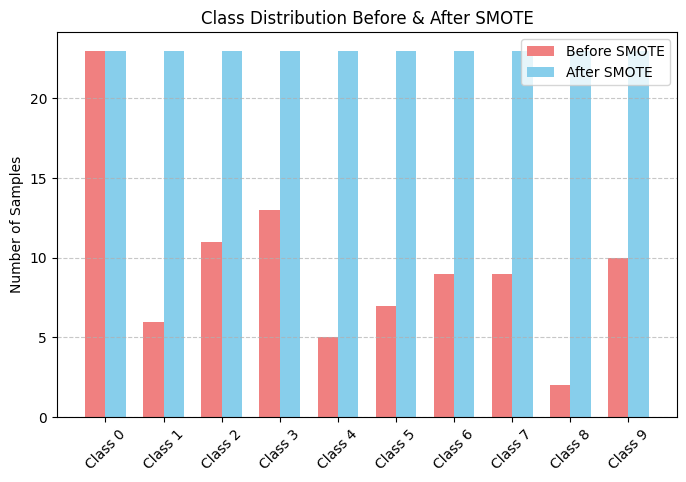

In [25]:
smoteDistr(y_train_all['Random Forest'], y_train)

## Before tuning evaluate model

In [26]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        report = classification_report(y_test, preds, target_names=label_encoder.classes_, output_dict=True)
        
        print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")


In [27]:
# models={
#     "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
#     "Ada Boost":AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42),
#     "XGBC":  XGBClassifier( eval_metric="mlogloss")
# }


# for model_name, model in models.items():
#     print(f"\n📌 {model_name} using {choiceOfEncoding[model_name].__name__} Results:")
#     evaluate_model(model, X_train_all[model_name], X_test_all[model_name], y_train_all[model_name], y_test)

*Results using best tokenizers* <br>
*without gridsearch*

📌 Random Forest using latex_tokenizer Results:
Accuracy: 0.7269

📌 Ada Boost using latex_tokenizer Results:
Accuracy: 0.5031

📌 XGBC using tfidf Results:
Accuracy: 0.7372

# Grid search

In [28]:
def tune_model(model_name, params, X_train, y_train):
    models={
        "Random Forest": RandomForestClassifier(random_state=42),
        "Ada Boost":AdaBoostClassifier(DecisionTreeClassifier(),random_state=42),
        "XGBC":  XGBClassifier( eval_metric="mlogloss")
    }
    model=models[model_name]


    grid_search = GridSearchCV(model, param_grid=params, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    print("Best Parameters from Grid Search:", grid_search.best_params_)
    return grid_search.best_estimator_


# **Hyperparameter Grids**
params={
    'Random Forest' : {
    'n_estimators': [100,500,1000,1400],  # Increasing upper limit for more trees  
    'max_depth': [None],  # Allowing "None" for full depth exploration  
    'min_samples_split': [2, 5, 10],  # Trying a lower value (2) for more splits  
    # 'min_samples_leaf': [1, 3, 5],  # Allowing leaf nodes with just 1 sample  
    'max_features': ['log2'],   #Adding 'log2' to test another heuristic  
    'bootstrap': [False, True]  # Bootstrapping helps with variance reduction
    },
    'XGBC' : {"n_estimators": [500,1000], "learning_rate": [0.01,0.1], "max_depth": [None]},
    'Ada Boost' : {
        "n_estimators": [50, 100],  # Keep two values for efficiency
        "learning_rate": [0.01, 0.1, 1.0],  # Remove 0.001 (too low)
        "estimator__max_depth": [2, 3],  # Keep max_depth around current value
        "estimator__min_samples_split": [2, 5],  # Remove 10 (less impact)
    }
}



In [29]:
# best_model = {}
# for model_name, param in params.items():
#     if model_name=='Random Forest' or model_name=='Ada Boost':
#         continue
#     print(f"\n📌 {model_name} best hyperparameters: ")
#     best_model[model_name] = tune_model(model_name, param, X_train_all[model_name], y_train_all[model_name])

*Accuracy score*

📌 Random Forest best hyperparameters: 
Best Parameters from Grid Search: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 1400}

📌 Ada Boost best hyperparameters: 
Best Parameters from Grid Search: {'estimator__max_depth': 3, 'estimator__min_samples_split': 2, 'learning_rate': 0.01, 'n_estimators': 100}

📌 XGBC best hyperparameters: 
Best Parameters from Grid Search: {DecisionTreeClassifier(max_depth=3,min_samples_split=2), 'learning_rat':0.1, 'max_dept': 6, 'n_estimators':200}


# Best Model

In [30]:
best_model={
    "Random Forest": RandomForestClassifier(bootstrap= False, max_depth= None, max_features= 'log2', min_samples_split= 2, n_estimators= 1400, random_state=42),
    "Ada Boost":AdaBoostClassifier(DecisionTreeClassifier(max_depth=None,min_samples_split=3), learning_rate= 0.01, n_estimators= 1400, random_state=42),
    "XGBC":  XGBClassifier( eval_metric="mlogloss",learning_rate=0.1, max_depth= 6, n_estimators=200) 
}

In [31]:
for model_name, model in best_model.items():
    print(f"\n📌 {model_name} using {choiceOfEncoding[model_name].__name__} Results:")
    evaluate_model(best_model[model_name], X_train_all[model_name], X_test_all[model_name], y_train_all[model_name], y_test)


📌 Random Forest using latex_tokenizer Results:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6250

📌 Ada Boost using latex_tokenizer Results:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4583

📌 XGBC using latex_tokenizer Results:
Accuracy: 0.3750


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Outcome summary

*Using tunned models:*

best_model={
    "Random Forest": RandomForestClassifier(bootstrap= False, max_depth= None, max_features= 'log2', min_samples_split= 2, n_estimators= 1400, random_state=42),
        "Ada Boost":AdaBoostClassifier(DecisionTreeClassifier(max_depth=None,min_samples_split=3), learning_rate= 0.01, n_estimators= 1400, random_state=42),
    "XGBC":  XGBClassifier( eval_metric="mlogloss",learning_rate=0.1, max_depth= 6, n_estimators=200) 
}




*Primary Data: python extraction: book1* 

📌 Random Forest using latex_tokenizer Results:
Accuracy:  0.7413

📌 Ada Boost using latex_tokenizer Results:
Accuracy: Accuracy: 0.7187

📌 XGBC using tfidf Results:
Accuracy: 0.7495

📌 XGBC using latex_tokenizer Results:
Accuracy: 0.7392

*Synthetic Data: book1*

📌 Random Forest using latex_tokenizer Results:
Accuracy: 0.8326

📌 Ada Boost using latex_tokenizer Results:
Accuracy: 0.6495

📌 XGBC using tfidf Results:
Accuracy: 0.7872

📌 XGBC using latex_tokenizer Results:
Accuracy: 0.8044

*Noiseless Data: book3*

📌 Random Forest using latex_tokenizer Results:
Accuracy: 0.6250

📌 Ada Boost using latex_tokenizer Results:
Accuracy: 0.4583

📌 XGBC using tfidf Results:
Accuracy: 0.4583

📌 XGBC using latex_tokenizer Results:
Accuracy: 0.3750
